# Bird Conservation
![from https://www.birdlife.org/papers-reports/making-a-difference/](https://www.birdlife.org/wp-content/uploads/2021/03/BirdLife_careers_bee-eater_3.jpg)

## Overview

The International Union for Conservation of Nature (IUCN) created the “Red List of Threatened Species” in 1964, which according to [their website](https://www.iucnredlist.org/) is “the world’s most comprehensive information source on the global conservation status of animal, fungi and plant species.” The IUCN maintains data pertaining to over 138,300 species in order to determine whether or not they are threatened with global extinction. Given the significant amount of labor it takes to maintain data on all of these species, our firm’s goal is to help the IUCN better predict which species will soon be at risk of extinction, which will hopefully help them direct their efforts in a more effective and targeted fashion. We hope to help the IUCN with all species, but in order to demonstrate our firm’s capabilities, we are focusing specifically on data pertaining to bird species for the purposes of this notebook.

## Business Problem

Our task is analyzing data pertaining to birds in order to assess whether or not each species is ‘threatened” or “not threatened” with global extinction. This information is valuable to the IUCN given that they will be able to direct their conservation efforts toward those species at greater risk of extinction. The Red List is updated every year for a subset of bird species with an extensive overhaul of each species every 4 years, so our hope is that our model will help the IUCN be able to direct their conservation efforts as effectively as possible. 

The IUCN Red List uses these 9 categories for all species to assess their threat level:

1) Not Evaluated (NE)\
2) Data Deficient (DD)\
3) Least Concern (LC)\
4) Near Threatened (NT)\
5) Vulnerable (VU)\
6) Endangered (EN)\
7) Critically Endangered (CR)\
8) Extinct in the Wild (EW)\
9) Extinct (EX)

![IUCN Red List Categories, from https://www.birdlife.org/projects/red-list/](https://www.birdlife.org/wp-content/uploads/2021/02/1000px-status_iucn3.1.svg_.png)

The IUCN Red List guidelines seem to err on the side of caution when making their assessments ([see Table 2.1 on p. 16 of the attached PDF](https://cmsdocs.s3.amazonaws.com/RedListGuidelines.pdf)). This is understandable given that it is likely easier to save a great number of species from extinction if more species are considered “threatened.” 

This target variable will be binned as a binary target. Looking at the above graphic, the categories from EX to VU will be considered "Threatened," while NT and LC will be considered "Not Threatened." This definition differs from the the Red List's official definition of threatened species. We decided to include EX and EW species as "Threatened" since these examples are the negative end consequence of a species being considered threatened, so there might be useful signal in these examples. Note that the IUCN has a ninth category “not evaluated” which is not pictured on the graphic above—this category is not included in the data set given that the IUCN has not included data on these species. 

The dataset includes two additional categories. CR(PE) will be considered "Threatened." DD, the data deficient designation, will be held out of the dataset entirely. One of the takeaways from our model will be a prediction of the threatened status of these 41 DD species, along with a recommendation to prioritize such species in scientific data collection and evaluation by IUCN and Bird Life partners.

Given that the IUCN tends to err on the side of caution when making their assessments, we have decided it would be in our best interest to follow suit. In this sense, we will optimize our models for “recall” over “precision,” in that we are interested in minimizing the number of false negatives rather than false positives. In the context of this business problem, a false negative would be represented by identifying a species as not threatened when in reality they are, which means the relevant authorities could potentially miss the fact that these species are at risk of becoming extinct before it is too late. A false positive would be represented by identifying a species as threatened when in reality they are not, which might mean allocating resources to conserving this species that are not necessarily needed. While this is also potentially a problem, our understanding is that this is a less serious problem than false negatives in this context.

## Data Understanding

The data used in this notebook was initially prepared by two of our colleagues, Jeff Marvel and Crystal Gould Perrott. [Find their GitHub repository here](https://github.com/marvelje/bird-data-exploration). We made edits to this data which will be described in more detail below, but here are descriptions of the original data sources in the order they appear in the original data set:

- [Ecological Society of America](https://figshare.com/collections/EltonTraits_1_0_Species-level_foraging_attributes_of_the_world_s_birds_and_mammals/3306933)
    - Information pertaining to family name, diet, foraging strategy, and body mass.
        - The family names are strings that identify each species in Latin and English. Body mass is a measurement of each species’s average weight in grams. The other categories were already formatted in a binary fashion by our colleagues Jeff and Crystal, indicating that each bird species either does or does not belong to a particular category.
- [Bird Life International](https://www.birdlife.org/)
    - Information pertaining to family name, Global IUCN Red List Category, endemic breeding status, migratory status, region(s) in which the bird is primarily found, threat types facing each bird species, and the terrain type where each species is primarily found.
        - The Global IUCN Red List Category is a categorical column containing one of the above 8 labels corresponding to each bird’s threatened status. This is the data we used as our target variable for all models run in the notebook. In order to make this a binary feature, we binned this data so that “threatened” species correspond to a “1” (includes VU, EN, CR, EW, and EX labels) while “not threatened” species correspond to a “0” (includes NT and LC labels). As stated above, we left DD species out of our modeling so that we could predict their status later using our final model, and NE species are not represented in this data set.
        - The family names are strings that identify each species in Latin and English. The remaining columns (endemic breeding, migratory status, regions, threat types, and terrain types) were already formatted in a binary fashion by our colleagues Jeff and Crystal, indicating that each bird species either does or does not belong to a particular category.
- It is important to note that there is an imbalance in our data when considering the target variable (threatened/not threatened). Based on how we binned the IUCN Global Red List Category, roughly 13% of the bird species in this data set are considered “threatened” with the remaining 87% being “not threatened.” 

In [84]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.dummy import DummyClassifier

pd.set_option('display.max_columns', None)
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

In [2]:
# custom function to evaluate models
from utils import evaluate

In [3]:
# load the data, take a look
df = pd.read_csv("data/bird_dataset.csv", index_col=0)
df.head()

C:\Users\whitm\Anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SpecID,PassNonPass,IOCOrder,BLFamilyLatin,BLFamilyEnglish,BLFamSequID,Taxo,Scientific,English,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,Diet-5Cat,Diet-Source,Diet-Certainty,Diet-EnteredBy,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-Source,ForStrat-SpecLevel,ForStrat-EnteredBy,Nocturnal,BodyMass-Value,BodyMass-Source,BodyMass-SpecLevel,BodyMass-Comment,Record-Comment,Unnamed: 0.1,English name,Family,Global IUCN Red List Category,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland
1,37.0,Nonpasseriformes,Rheiformes,Rheidae,Rheas,3.0,BL3,Rhea americana,Greater Rhea,20.0,10.0,10.0,0.0,0.0,0.0,20.0,0.0,20.0,20.0,Omnivore,Ref_1,A,Jennifer,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,Ref_1,1.0,Jessica,0.0,23000.00,Dunning08,1.0,NaN,NaN,2.0,Greater Rhea,Rheidae (Rheas),NT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,38.0,Nonpasseriformes,Rheiformes,Rheidae,Rheas,3.0,BL3,Rhea pennata,Lesser Rhea,20.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,30.0,40.0,PlantSeed,Ref_1,A,Jennifer,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,Ref_1,1.0,Jessica,0.0,23900.00,Dunning08,1.0,NaN,NaN,3.0,Lesser Rhea,Rheidae (Rheas),LC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45.0,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.0,BL3,Casuarius casuarius,Southern Cassowary,10.0,0.0,0.0,0.0,10.0,0.0,80.0,0.0,0.0,0.0,FruiNect,Ref_1,A,Jennifer,0.0,0.0,80.0,20.0,0.0,0.0,0.0,0.0,Ref_1,1.0,Jessica,0.0,44000.00,Dunning08,1.0,NaN,NaN,52.0,Southern Cassowary,"Casuariidae (Cassowaries, Emus)",LC,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,46.0,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.0,BL3,Casuarius bennetti,Dwarf Cassowary,10.0,0.0,0.0,0.0,10.0,0.0,80.0,0.0,0.0,0.0,FruiNect,Ref_1,B,Jennifer,0.0,0.0,80.0,20.0,0.0,0.0,0.0,0.0,Ref_1,1.0,Jessica,0.0,34999.99,Dunning08,1.0,NaN,NaN,53.0,Dwarf Cassowary,"Casuariidae (Cassowaries, Emus)",LC,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5,47.0,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.0,BL3,Casuarius unappendiculatus,Northern Cassowary,20.0,0.0,0.0,0.0,10.0,0.0,60.0,0.0,0.0,10.0,FruiNect,Ref_1,A,Jennifer,0.0,0.0,80.0,20.0,0.0,0.0,0.0,0.0,Ref_1,1.0,Jessica,0.0,46073.85,Dunning08,1.0,NaN,NaN,54.0,Northern Cassowary,"Casuariidae (Cassowaries, Emus)",LC,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9597 entries, 1 to 9985
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SpecID                         9597 non-null   float64
 1   PassNonPass                    9597 non-null   object 
 2   IOCOrder                       9597 non-null   object 
 3   BLFamilyLatin                  9597 non-null   object 
 4   BLFamilyEnglish                9597 non-null   object 
 5   BLFamSequID                    9597 non-null   float64
 6   Taxo                           9597 non-null   object 
 7   Scientific                     9597 non-null   object 
 8   English                        9597 non-null   object 
 9   Diet-Inv                       9597 non-null   float64
 10  Diet-Vend                      9597 non-null   float64
 11  Diet-Vect                      9597 non-null   float64
 12  Diet-Vfish                     9597 non-null   f

In [5]:
# confirm each record is a unique species
assert df['Scientific'].nunique() == len(df)

In [6]:
# columns with missing data
missing_columns = df.isna().sum()
missing_columns[missing_columns != 0]

Diet-EnteredBy       272
BodyMass-Comment    9267
Record-Comment      9372
dtype: int64

- There are 9597 entries, each representing a unique species of birds. There are about 11,000 bird species globally.
- There are 85 columns, some of which are not useful for predicting a bird's threatened status, such as the columns with metadata concerning data entry (eg. `Diet-EnteredBy`, `Record-Comment`) and unique IDs/names (eg. `SpecID`, `English`).
- The three columns with null values are metadata that will not be used for prediction.

Let's take a look at the target variable.

In [7]:
df['Global IUCN Red List Category'].value_counts()

LC        7448
NT         859
VU         685
EN         376
CR         167
DD          41
CR(PE)      11
EX           5
EW           5
Name: Global IUCN Red List Category, dtype: int64

Before any further exploration of the data, including its relevant features and the distribution of the binary target, we need to do some cleaning and splitting.

## Data Preparation

- Based on our business understanding, we decided to drop the following 18 columns from the data set given that they were not going to impact our analysis:
    - `SpecID`, `IOCOrder`, `BLFamilyLatin`, `BLFamilyEnglish`, `BLFamSequID`, `Taxo`, `Scientific`, `English`, `Diet-Source`, `Diet-EnteredBy`, `ForStrat-Source`, `ForStrat-EnteredBy`, `BodyMass-Comment`, `BodyMass-Source`, `Record-Comment`, `Unnamed: 0.1`, `English name`, `Family`
- We created a new data frame containing all of the 41 bird species labeled as DD for testing later on. These 41 rows were then dropped from our set before doing a train-test split.
- We also created a new column ‘threatened’ with a binary label pertaining to each species threatened status as indicated by the Global IUCN Red List Category data. All LC and NT labels were given a 0 for “not threatened,” while all VU, EN, CR, EW, and EX were given a 1 for “threatened.” 

The following columns containing data entry metadata and IDs/names are filtered out of the dataset.

In [8]:
# create df with useful columns
drop_cols = ['SpecID','IOCOrder', 'BLFamilyLatin', 'BLFamilyEnglish', 'BLFamSequID', 'Taxo', 'Scientific', 'English',
             'Diet-Source', 'Diet-EnteredBy', 'ForStrat-Source', 'ForStrat-EnteredBy', 'BodyMass-Source',
             'BodyMass-Comment', 'Record-Comment', 'Unnamed: 0.1', 'English name', 'Family']

bird_df = df.drop(columns=drop_cols)
bird_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9597 entries, 1 to 9985
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PassNonPass                    9597 non-null   object 
 1   Diet-Inv                       9597 non-null   float64
 2   Diet-Vend                      9597 non-null   float64
 3   Diet-Vect                      9597 non-null   float64
 4   Diet-Vfish                     9597 non-null   float64
 5   Diet-Vunk                      9597 non-null   float64
 6   Diet-Scav                      9597 non-null   float64
 7   Diet-Fruit                     9597 non-null   float64
 8   Diet-Nect                      9597 non-null   float64
 9   Diet-Seed                      9597 non-null   float64
 10  Diet-PlantO                    9597 non-null   float64
 11  Diet-5Cat                      9597 non-null   object 
 12  Diet-Certainty                 9597 non-null   o

There are now 67 columns, including the target variable to be binned. Let's do that now.

First, we'll extract the DD species and store them for later, then we'll bin the remaining species.

In [9]:
# create a dataframe containing the DD species
dd_df = bird_df[bird_df['Global IUCN Red List Category'] == 'DD']

# drop the target column, as the ground truth of the binary target of "Threatened" or "Not Threatened" is unknown
dd_df = dd_df.drop(columns='Global IUCN Red List Category')
dd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 492 to 9535
Data columns (total 66 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassNonPass                41 non-null     object 
 1   Diet-Inv                   41 non-null     float64
 2   Diet-Vend                  41 non-null     float64
 3   Diet-Vect                  41 non-null     float64
 4   Diet-Vfish                 41 non-null     float64
 5   Diet-Vunk                  41 non-null     float64
 6   Diet-Scav                  41 non-null     float64
 7   Diet-Fruit                 41 non-null     float64
 8   Diet-Nect                  41 non-null     float64
 9   Diet-Seed                  41 non-null     float64
 10  Diet-PlantO                41 non-null     float64
 11  Diet-5Cat                  41 non-null     object 
 12  Diet-Certainty             41 non-null     object 
 13  ForStrat-watbelowsurf      41 non-null     float

In [10]:
# remove the DD species from the bird_df
bird_df = bird_df.drop(index=dd_df.index)

# create the binary target variable; NT and LC are the only "Not Threatened" Red List categories
bird_df['threatened'] = [0.0 if _ in ['NT', 'LC'] else 1.0 for _ in bird_df['Global IUCN Red List Category']]
bird_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9556 entries, 1 to 9985
Data columns (total 68 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PassNonPass                    9556 non-null   object 
 1   Diet-Inv                       9556 non-null   float64
 2   Diet-Vend                      9556 non-null   float64
 3   Diet-Vect                      9556 non-null   float64
 4   Diet-Vfish                     9556 non-null   float64
 5   Diet-Vunk                      9556 non-null   float64
 6   Diet-Scav                      9556 non-null   float64
 7   Diet-Fruit                     9556 non-null   float64
 8   Diet-Nect                      9556 non-null   float64
 9   Diet-Seed                      9556 non-null   float64
 10  Diet-PlantO                    9556 non-null   float64
 11  Diet-5Cat                      9556 non-null   object 
 12  Diet-Certainty                 9556 non-null   o

Now we'll split the data into train (75%), test (15%), and holdout (10%) sets. The test set will be used for iterative model evaluation. We'll reserve the holdout set for evaluation of our final model at the end. The holdout set is necessary to judge the generalizabililty of our model on unseen data.

In [11]:
# create the X (features) and y (target)
X = bird_df.drop(columns=['Global IUCN Red List Category', 'threatened'])
y = bird_df['threatened']

# split into a 10% holdout set
X_t, X_hold, y_t, y_hold = train_test_split(X, y, random_state=42, stratify=y, test_size=0.1)

# split into 75% train, 15% test sets
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, random_state=42, stratify=y_t, test_size=15/90)

With the data preliminarily cleaned and split, let's finally take a closer look to see what other steps need to be taken before modeling.

In [12]:
y_train.value_counts(normalize=True)

0.0    0.869244
1.0    0.130756
Name: threatened, dtype: float64

The distribution of the target variable can be seen above. There are about 13% positives, or threatened bird species. This means there is some class imbalance we will need to be aware of in the modeling and evaluation process.

Next, we'll examine the features.

In [13]:
# number of numeric features
print(len(X_train.describe().columns))

63


In [14]:
# summary stats for categorical features
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
print(len(cat_cols))
X_train[cat_cols].describe()

3


,PassNonPass,Diet-5Cat,Diet-Certainty
count,7166,7166,7166
unique,2,5,5
top,Passeriformes,Invertebrate,A
freq,4238,3594,5719


On the surface, we have 63 numeric and 3 categorical features. Let's start describing the categorical ones.

In [15]:
X_train['PassNonPass'].value_counts()

Passeriformes       4238
Nonpasseriformes    2928
Name: PassNonPass, dtype: int64

In [16]:
X_train['Diet-5Cat'].value_counts()

Invertebrate    3594
Omnivore        1179
FruiNect        1141
PlantSeed        783
VertFishScav     469
Name: Diet-5Cat, dtype: int64

In [17]:
X_train['Diet-Certainty'].value_counts()

A     5719
B      572
D1     517
C      258
D2     100
Name: Diet-Certainty, dtype: int64

- `PassNonPass` is a binary indicator for whether the bird is passerine, or has feet for perching.
- `Diet-5Cat` is a nominal feature indicating the diet of the bird.
- `Diet-Certainty` is an ordinal feature indicating the quality of the source of diet information. A-C are species-level data, while D1 and D2 are genus and family-level data, respectively.

In [18]:
# summary stats for numeric features
X_train.describe()

,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-SpecLevel,Nocturnal,BodyMass-Value,BodyMass-SpecLevel,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland
count,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000,7166.000000
mean,55.496790,2.641641,2.190901,2.687692,0.355847,0.602847,14.991627,5.908457,10.747977,4.376221,2.545353,4.673458,31.773095,23.470695,23.457717,12.075914,1.963020,0.027351,0.966369,0.030282,276.131246,0.917527,0.255512,0.191181,0.227184,0.009768,0.308959,0.129221,0.080659,0.118197,0.057912,0.054005,0.003628,0.059308,0.126570,0.035445,0.337566,0.192995,0.202903,0.116104,0.048981,0.004605,0.036562,0.076472,0.049121,0.062517,0.039771,0.094195,0.030701,0.356126,0.002931,0.016606,0.570472,0.162852,0.000279,0.037399,0.041167,0.040190,0.015211,0.037678,0.150293,0.304912,0.160620
std,37.121068,12.306244,7.734272,12.171346,3.875102,5.390484,25.644925,19.287504,21.825901,13.516224,14.121261,17.301505,37.750529,25.767692,26.254907,21.588089,10.540039,0.163117,0.180290,0.171374,1707.292292,0.275103,0.436179,0.393258,0.419042,0.098358,0.462096,0.335468,0.272329,0.322864,0.233594,0.226043,0.060130,0.236216,0.332514,0.184915,0.472913,0.394676,0.402189,0.320372,0.215844,0.067709,0.187696,0.265771,0.216135,0.242110,0.195435,0.292120,0.172517,0.478887,0.054059,0.127799,0.495043,0.369257,0.016705,0.189750,0.198689,0.196418,0.122399,0.190429,0.357383,0.460402,0.367205
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,15.137500,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,60.00

- There are 10 `Diet-` and 7 `ForStrat-` numeric columns representing bird diets and foraging strategies, respectively. Each set of features sum to 100 for each record, or bird species.
- `BodyMass-Value` is the geometric mean of the average mass by sex of the bird species in grams.
- The remaining 45 columns are all binary indicators.
    - Of these, there are 13 geographic regions, 11 threat types, and 15 habitat categories, along with a few miscellaneous features, like whether the bird is nocturnal or migratory.
    - `ForStrat-SpecLevel` and `BodyMass-SpecLevel` are both binary indicators for whether the respective data are species-level data (1.0) or genus/family-level (0.0).

The data prepartion strategy is:
   1. Apply the following to X_train, X_test, X_hold, dd_df:
- Transform the `PassNonPass` binary categorical column into a binary numeric column.
- Bin the `Diet-Certainty` column to a binary numeric column indicating either species-level (1.0) or genus/family-level (0.0).


   2. Construct a preprocessing pipeline to efficiently handle different data types:
- One-hot encode the remaining categorical feature, `Diet-5Cat`.
- Normalize the `BodyMass-Value` feature by min-max scaling to compress the range to 0-1.
- Normalize the proportional `Diet-` and `ForStrat-` numeric columns by dividing by 100 to put them on a 0-1 scale.

Now all the features will be on the same scale, which is necessary for linear and distance-based modeling, such as Logistic Regression or KNN.

In [19]:
# transform binary categorical to binary numeric
X_train['PassNonPass'] = [1.0 if _ == 'Passeriformes' else 0.0 for _ in X_train['PassNonPass']]
X_test['PassNonPass'] = [1.0 if _ == 'Passeriformes' else 0.0 for _ in X_test['PassNonPass']]
X_hold['PassNonPass'] = [1.0 if _ == 'Passeriformes' else 0.0 for _ in X_hold['PassNonPass']]
dd_df['PassNonPass'] = [1.0 if _ == 'Passeriformes' else 0.0 for _ in dd_df['PassNonPass']]

# Bin the categorical column to a binary numeric
X_train['Diet-Certainty'] = [0.0 if _ in ['D1', 'D2'] else 1.0 for _ in X_train['Diet-Certainty']]
X_test['Diet-Certainty'] = [0.0 if _ in ['D1', 'D2'] else 1.0 for _ in X_test['Diet-Certainty']]
X_hold['Diet-Certainty'] = [0.0 if _ in ['D1', 'D2'] else 1.0 for _ in X_hold['Diet-Certainty']]
dd_df['Diet-Certainty'] = [0.0 if _ in ['D1', 'D2'] else 1.0 for _ in dd_df['Diet-Certainty']]

X_train.head()

<ipython-input-19-6166c74afec3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['PassNonPass'] = [1.0 if _ == 'Passeriformes' else 0.0 for _ in X_train['PassNonPass']]
<ipython-input-19-6166c74afec3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['PassNonPass'] = [1.0 if _ == 'Passeriformes' else 0.0 for _ in X_test['PassNonPass']]
<ipython-input-19-6166c74afec3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,PassNonPass,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,Diet-5Cat,Diet-Certainty,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-SpecLevel,Nocturnal,BodyMass-Value,BodyMass-SpecLevel,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland
2742,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,Invertebrate,0.0,0.0,30.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.51,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5973,1.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Invertebrate,1.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,1.0,0.0,37.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8488,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,PlantSeed,1.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,1.0,0.0,13.27,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6095,1.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Invertebrate,1.0,0.0,0.0,0.0,80.0,20.0,0.0,0.0,0.0,1.0,0.0,11.40,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5016,1.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Invertebrate,0.0,0.0,0.0,60.0,40.0,0.0,0.0,0.0,0.0,1.0,0.0,13.00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [20]:
# categorical column to be OHE
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
cat_cols

['Diet-5Cat']

In [21]:
# continuous numeric column to be min-max scaled
num_cols = ['BodyMass-Value']

In [22]:
# proportional columns to be divided by 100
diets = [c for c in X_train.columns if re.search('Diet.+', c)][:10]
strats = [c for c in X_train.columns if re.search('ForStrat.+', c)][:7]

prop_cols = [*diets, *strats]
prop_cols

['Diet-Inv',
 'Diet-Vend',
 'Diet-Vect',
 'Diet-Vfish',
 'Diet-Vunk',
 'Diet-Scav',
 'Diet-Fruit',
 'Diet-Nect',
 'Diet-Seed',
 'Diet-PlantO',
 'ForStrat-watbelowsurf',
 'ForStrat-wataroundsurf',
 'ForStrat-ground',
 'ForStrat-understory',
 'ForStrat-midhigh',
 'ForStrat-canopy',
 'ForStrat-aerial']

In [23]:
# categorical pipeline
cat_pipe = Pipeline([('ohe', OneHotEncoder())])

# numeric pipeline
num_pipe = Pipeline([('min_max', MinMaxScaler())])

# proportional numeric pipeline
prop_pipe = Pipeline([('div100', FunctionTransformer(lambda x: x/100))])

# preprocessing pipeline, allow the untransformed columns to 'passthrough'
preprocessor = ColumnTransformer(transformers=[('categorical', cat_pipe, cat_cols),
                                               ('numerical', num_pipe, num_cols),
                                               ('proportional', prop_pipe, prop_cols)],
                                 remainder='passthrough')

With this `preprocessor` object, we will be able to easily prepare the training data for modeling. We will also be able to transform the test, holdout, and DD datasets based on fitting the `preprocessor` to the training data.

## Modeling and Evaluation

- We ran a variety of model types, but in order to effectively compare our results we created an “evaluate” function.
    - This function takes as inputs: 
        - A model
        - Training and testing data
        - A grid_search parameter
    - The output of this function includes: 
        - Accuracy, precision, recall, and f1 scores 
        - The “best parameters” and a summary data frame of each model run in the grid search 
        - A confusion matrix, ROC-AUC curve, and Precision-Recall curve for the test data
- Throughout our modeling process, we used the following model types:
    - Logistic regression
    - Decision trees
    - KNN
    - Random Forest
    - Bagged Trees
    - Naive Bayes
    - Boosted Trees
- All comments regarding individual model evaluation will be included in markdown/comments in the cells below

### Baseline Understanding

As a baseline, we will predict that a bird species is threatened at the base rate of ~13% found in the training data. This is how well our predictions would be if we knew nothing other than the proportion of threatened bird species.

Training Metrics
Accuracy: 0.774
Precision: 0.135
Recall: 0.134
f1: 0.135
----------
Testing Metrics
Accuracy: 0.771
Precision: 0.106
Recall: 0.102
f1: 0.104


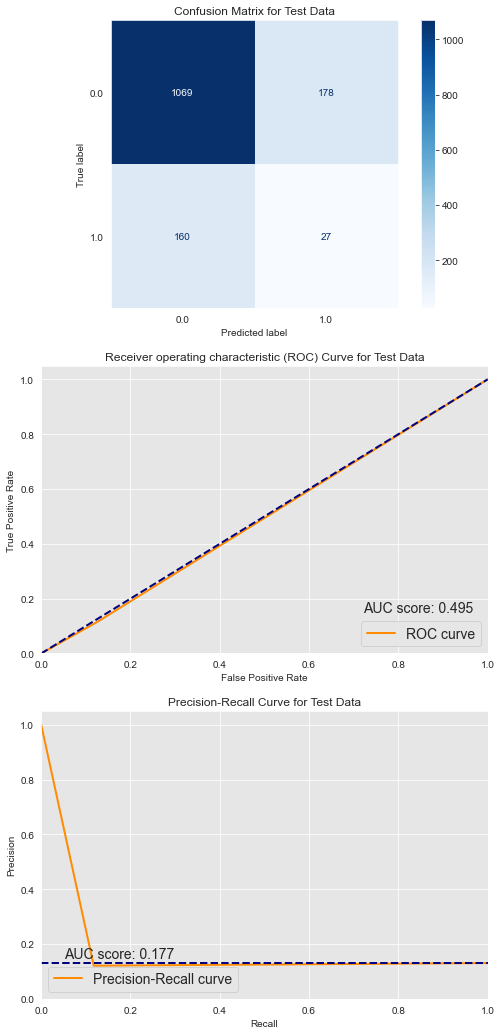

In [24]:
# baseline prediction of predicting threatened bird species at the base rate found in the train set
baseline = DummyClassifier(strategy='stratified')

# custom function to evaluate the model on test data
evaluate(baseline, X_train, y_train, X_test, y_test)

As expected, this baseline has room for improvement with both recall and precision scores of about 16% on the test data. A confusion matrix for the test set can be seen above, along with ROC and precision-recall curves. The baseline is by definition guessing randomly according to the base rate, as shown in the curves.

### First Model - Decision Tree

Since we have a large number of features that may have interactions among them, a first model will be an untuned decision tree using all the features available.

In [25]:
# decision tree pipeline
dt_pipe = Pipeline([('preprocessor', preprocessor),
                   ('dt', DecisionTreeClassifier())])

# relevant scoring metrics
scoring_metrics = ('recall', 'precision', 'f1')

# cross validation
dt_cv = cross_validate(dt_pipe, X_train, y_train, scoring=scoring_metrics)

print(f"Mean Validation Recall: {np.mean(dt_cv['test_recall']):.3f}")
print(f"Mean Validation Precision: {np.mean(dt_cv['test_precision']):.3f}")
print(f"Mean Validation f1: {np.mean(dt_cv['test_f1']):.3f}")

Mean Validation Recall: 0.571
Mean Validation Precision: 0.563
Mean Validation f1: 0.567


These metrics show some promise over the baseline based on mean CV scores. Let's evaluate on the test data.

Training Metrics
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1: 1.000
----------
Testing Metrics
Accuracy: 0.876
Precision: 0.524
Recall: 0.535
f1: 0.529


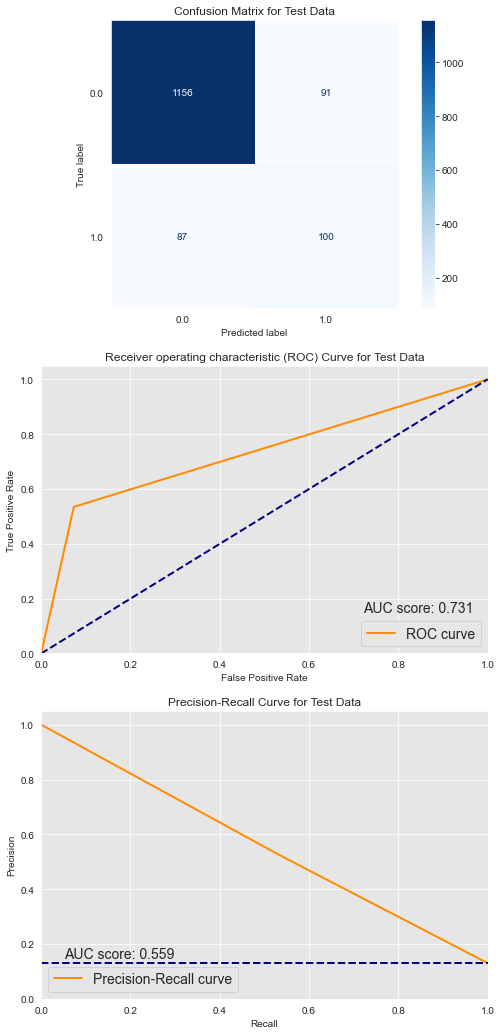

In [26]:
# custom function to evaluate the model on test data
evaluate(dt_pipe, X_train, y_train, X_test, y_test)

An untuned decision tree will inevitably overfit to the training data, as can be seen in the comparison of metrics for the training and testing data. The results on the test set are better than the baseline results, but the massive overfit means our model will not be generalizable, which contradicts our business goal.

### Decision Tree - Grid Search

We performed a grid search over the tree's hyperparameters since the first iteration is overfit to the train data. Limiting the maximum depth of the tree will not allow the tree to overfit as much. Increasing the minimum number of samples in the leaves from the default of 2 will also help the overfitting problem. The criterion for splitting may help our model's performance. Finally, 'balanced' class weights can help our model account for the class imbalance in the data.

In [27]:
# decision tree param grid
dt_grid = {'dt__max_depth': [3, 4, 5, 10],
          'dt__min_samples_leaf': [2, 5, 10, 20],
          'dt__criterion': ['gini', 'entropy'],
          'dt__class_weight': [None, 'balanced']}

dt_gs = GridSearchCV(estimator=dt_pipe, param_grid=dt_grid, scoring=scoring_metrics, refit='f1')

Training Metrics
Accuracy: 0.885
Precision: 0.533
Recall: 0.990
f1: 0.693
----------
Testing Metrics
Accuracy: 0.864
Precision: 0.489
Recall: 0.914
f1: 0.637

Best Parameters
{'dt__class_weight': 'balanced', 'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__min_samples_leaf': 20}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__class_weight,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_leaf,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
63,0.038360,0.009200,0.004720,0.006265,balanced,entropy,10,20,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.978723,0.925532,0.946524,0.941176,0.941176,0.946626,0.017519,25,0.533333,0.528875,0.511561,0.548287,0.539877,0.532387,0.012295,38,0.690432,0.673114,0.664165,0.692913,0.686160,0.681357,0.010977,1
62,0.035774,0.006175,0.012504,0.006252,balanced,entropy,10,10,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.946809,0.930851,0.903743,0.930481,0.919786,0.926334,0.014213,27,0.532934,0.522388,0.528125,0.555911,0.547771,0.537426,0.012502,37,0.681992,0.669216,0.666667,0.696000,0.686627,0.680100,0.010935,2
61,0.034437,0.006384,0.012496,0.006248,balanced,entropy,10,5,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.909574,0.893617,0.855615,0.909091,0.935829,0.900745,0.026329,30,0.549839,0.521739,0.546075,0.553746,0.553797,0.545039,0.011996,33,0.685371,0.658824,0.666667,0.688259,0.695825,0.678989,0.013918,3
45,0.034368,0.006252,0.009371,0.007651,balanced,gini,10,5,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.893617,0.925532,0.903743,0.909091,0.882353,0.902867,0.014557,29,0.549020,0.527273,0.550489,0.548387,0.540984,0.543230,0.008631,35,0.680162,0.671815,0.684211,0.684105,0.670732,0.678205,0.005855,4
47,0.037490,0.007651,0.009373,0.007653,balanced,gini,10,20,"{'dt__class_weight': 'balanced', 'dt__criterio...",0.952128,0.936170,0.941176,0.951872,0.973262,0.950922,0.012759,24,0.523392,0.526946,0.510145,0.541033,0.532164,0.526736,0.010202,40,0.675472,0.674330,0.661654,0.689922,0.688091,0.677894,0.010305,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,0.037481,0.007655,0.009378,0.007657,None,gini,10,5,"{'dt__class_weight': None, 'dt__criterion': 'g...",0.606383,0.478723,0.556150,0.524064,0.577540,0.548572,0.044087,61,0.584615,0.608108,0.654088,0.649007,0.658537,0.630871,0.029295,25,0.595300,0.535714,0.601156,0.579882,0.615385,0.585487,0.027366,60
30,0.034365,0.006249,0.006249,0.007653,None,entropy,10,10,"{'dt__class_weight': None, 'dt__criterion': 'e...",0.542553,0.585106,0.556150,0.449198,0.540107,0.534623,0.045612,63,0.684564,0.643275,0.594286,0.608696,0.696552,0.645474,0.040286,14,0.605341,0.612813,0.574586,0.516923,0.608434,0.583619,0.035972,61
29,0.031247,0.000011,0.012489,0.006244,None,entropy,10,5,"{'dt__class_weight': None, 'dt__criterion': 'e...",0.659574,0.531915,0.598930,0.449198,0.556150,0.559153,0.070011,60,0.582160,0.578035,0.605405,0.613139,0.641975,0.604143,0.023146,31,0.618454,0.554017,0.602151,0.518519,0.595989,0.577826,0.036487,62
28,0.037491,0.007656,0.003125,0.006250,None,entropy,10,2,"{'dt__class_weight': None, 'dt__criterion': 'e...",0.627660,0.526596,0.556150,0.465241,0.524064,0.539942,0.052854,62,0.587065,0.607362,0.604651,0.630435,0.624204,0.610743,0.015350,30,0.606684,0.564103,0.579387,0.535385,0.569767,0.571065,0.023070,63


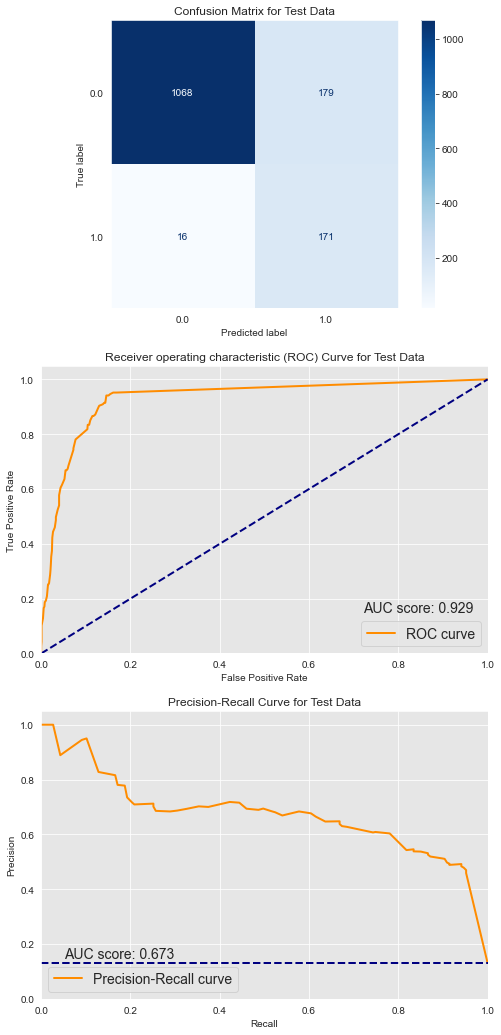

In [32]:
# evaluate on the test data
dt_gs_model = evaluate(dt_gs, X_train, y_train, X_test, y_test, grid_search=True)

Commentary

### Gradient Boosting

More complex tree models, such as random forests, baggers, and gradient boosted trees did not perform as well on the data. Such models were grid searched and evaluated on the test data in the individual modeling notebooks nested in the notebooks folder of this directory.

As an example, we will show the "best" gradient boosted tree after grid searching below.

In [85]:
# gradient boosting pipeline
gb_pipe = Pipeline([('preprocessor', preprocessor),
                   ('gb', GradientBoostingClassifier(learning_rate=0.01,
                                                     max_depth=10,
                                                     min_samples_leaf=10,
                                                     n_estimators=1000))])

# cross validation
gb_cv = cross_validate(gb_pipe, X_train, y_train, scoring=scoring_metrics)

print(f"Mean Validation Recall: {np.mean(gb_cv['test_recall']):.3f}")
print(f"Mean Validation Precision: {np.mean(gb_cv['test_precision']):.3f}")
print(f"Mean Validation f1: {np.mean(gb_cv['test_f1']):.3f}")

Mean Validation Recall: 0.652
Mean Validation Precision: 0.673
Mean Validation f1: 0.662


Training Metrics
Accuracy: 0.999
Precision: 0.999
Recall: 0.990
f1: 0.995
----------
Testing Metrics
Accuracy: 0.908
Precision: 0.647
Recall: 0.647
f1: 0.647


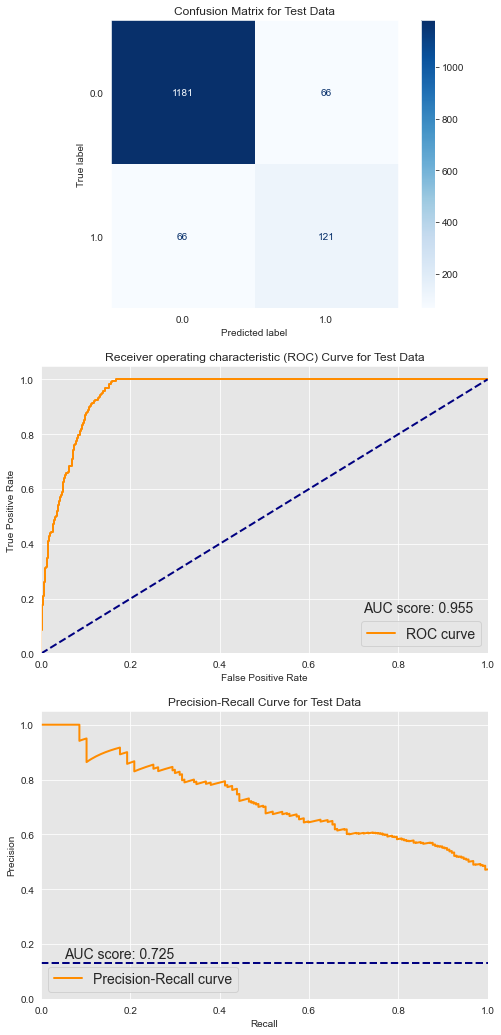

In [86]:
# evaluate on test data
evaluate(gb_pipe, X_train, y_train, X_test, y_test)

This gradient boosted tree is overfit based on the divergence between train and test metrics. The default parameters for the `GradientBoostingClassifier` actually produce a model with marginally worse test metrics (0.60 recall as opposed to 0.64 here; can be found in Andrew's modeling notebook), but the default tree appears to be less overfit. Nonetheless, these gradient boosted trees may have similar f1 scores to the best decision tree above, but they appear to be less generalizable and have worse recall scores on the test data (~0.6 to ~0.9).

### Logistic Regression

We ran various logistic regression models via grid search on our data (can be found in Scott's modeling notebook). The logistic regression models using all the features had trouble converging. In addition, there were very promising results when simply using the the 11 "threats" features from the data set to train the model. We will show this below.

In [29]:
# the threats features
threats = [c for c in df.columns if re.search('.+threat', c)]

# preprocessor to select only the threats features
preprocessor_logr = ColumnTransformer(transformers=[('threats', 'passthrough', threats)],
                                     remainder='drop')

In [30]:
# logistic regression pipeline
logr_pipe = Pipeline([('preprocessor_logr', preprocessor_logr),
                   ('logr', LogisticRegression(class_weight='balanced'))])

# cross validation
logr_cv = cross_validate(logr_pipe, X_train, y_train, scoring=scoring_metrics)

print(f"Mean Validation Recall: {np.mean(logr_cv['test_recall']):.3f}")
print(f"Mean Validation Precision: {np.mean(logr_cv['test_precision']):.3f}")
print(f"Mean Validation f1: {np.mean(logr_cv['test_f1']):.3f}")

Mean Validation Recall: 0.909
Mean Validation Precision: 0.531
Mean Validation f1: 0.670


The `class_weight` is set to 'balanced' to help the model learn from the imbalanced data. The mean 0.91 recall score on the validation folds is promising.

Training Metrics
Accuracy: 0.885
Precision: 0.536
Recall: 0.909
f1: 0.674
----------
Testing Metrics
Accuracy: 0.870
Precision: 0.502
Recall: 0.861
f1: 0.634


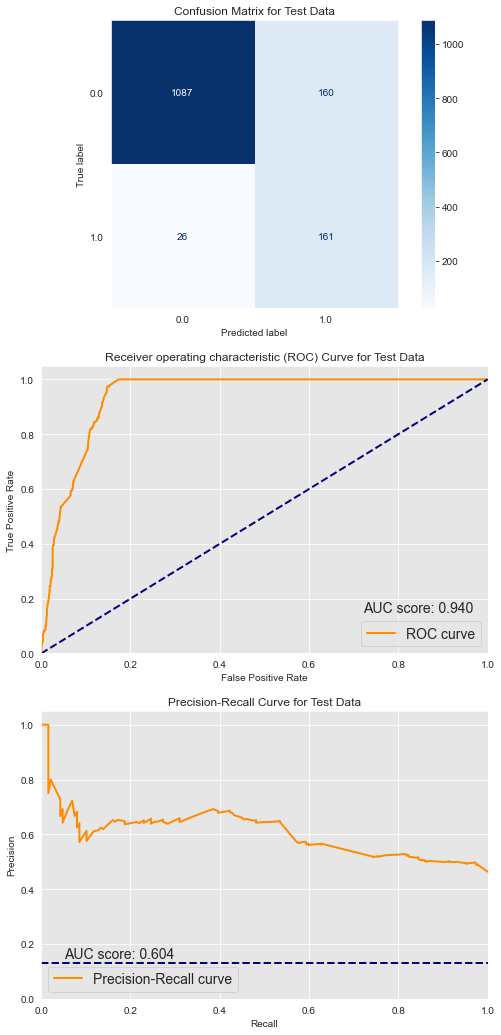

In [31]:
# evaluate on the test data
evaluate(logr_pipe, X_train, y_train, X_test, y_test)

Commentary

### KNN and Naive Bayes

In addition to logistic regression and various tree-based models, KNN and Naive Bayes models were fit and tested. However, both model types are troublesome for our data. KNN models with all 70 of our preprocessed features will suffer from the curse of dimensionality. With such high-dimensional space, distance measurements become unreliable. Naive Bayes methods have a strong assumption of independence between the features, which we know is not the case for the two sets of proportional columns. Also, we assume there is likely to be interaction between regions, habitats, and threats. For these reasons, these two model types were disregarded in the selection of our final model.

### 'Final' Model

We decided to build a stacked model for our final model. The contributing models are:
1. The decision tree trained on all features of our data.
2. The logistic regression model trained on the threats features.

The decision tree had test recall and precision scores of 0.91 and 0.49, respectively, and a precision-recall AUC of 0.67. The logistic regression had test recall and precision scores of 0.86 and 0.50, respectively, and a precision-recall AUC of 0.60. Both appeared to be slightly overfit.

We build a stacked model which weights the input models evenly and uses the class probabilities, not merely the predicted labels, when making predictions.

Training Metrics
Accuracy: 0.887
Precision: 0.536
Recall: 0.984
f1: 0.694
----------
Testing Metrics
Accuracy: 0.868
Precision: 0.496
Recall: 0.925
f1: 0.646


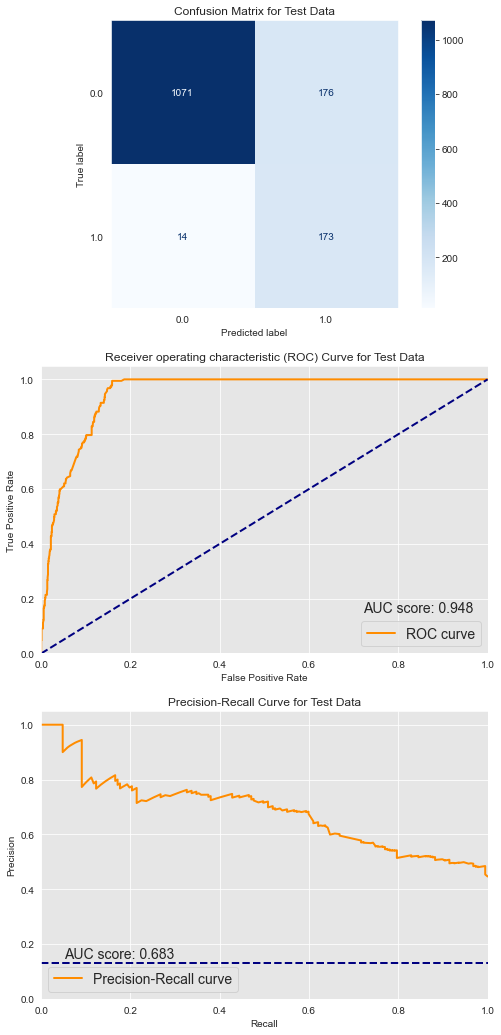

In [74]:
# stacked model with 50/50 weights and 'soft' voting
final_model = VotingClassifier(estimators=[('dt', dt_gs_model.best_estimator_),
                                          ('logr', logr_pipe)],
                              voting='soft')

# evaluate on test data
evaluate(final_model, X_train, y_train, X_test, y_test)

The stacked model appears to be a slight improvement over either model by itself. The recall and precision scores on the test data are now 0.92 and 0.50, while the AUC is 0.68. Before any final evaluations, we need to bring back our holdout set to test our stacked model.

Training Metrics
Accuracy: 0.887
Precision: 0.536
Recall: 0.984
f1: 0.694
----------
Testing Metrics
Accuracy: 0.871
Precision: 0.504
Recall: 0.968
f1: 0.663


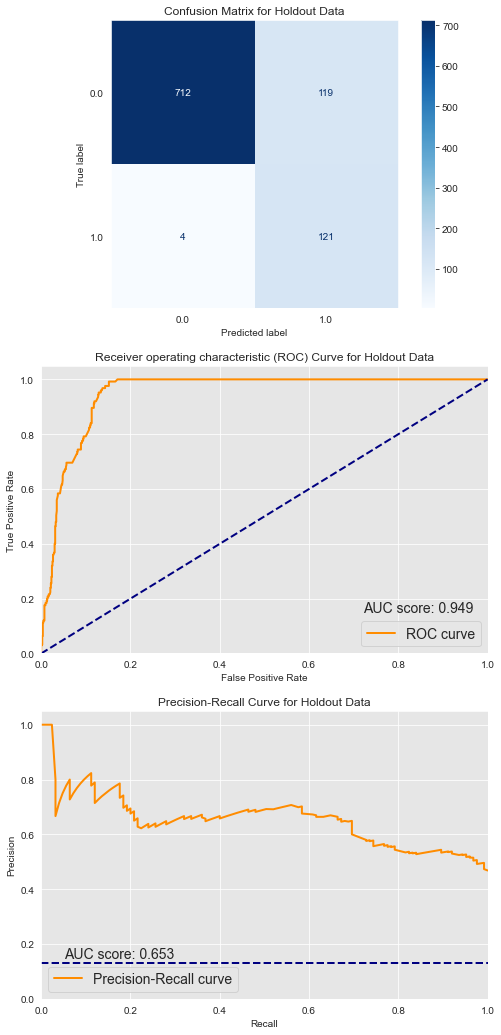

In [87]:
# evaluate the stacked model on the holdout set
evaluate(final_model, X_train, y_train, X_hold, y_hold, save_fig_path='images/holdout_eval')

Commentary

#### Feature Importance

In [92]:
# array of feature importance values for the decision tree
feature_importance_values = final_model.estimators_[0]['dt'].feature_importances_

# OHE feature names
ohe_cols = final_model.estimators_[0]['preprocessor'].transformers_[0][1]['ohe'].get_feature_names()

# features not transformed by the Column Transformer were passed through
remainder_cols = [c for c in X_train.columns if c not in [*cat_cols, *num_cols, *prop_cols]]

# preprocessor features are in order of the steps, followed by any 'passthrough' features in the remainder
feature_cols = [*ohe_cols, *num_cols, *prop_cols, *remainder_cols]

# create DataFrame with feature names and importance
feature_df = pd.DataFrame.from_dict(dict(zip(feature_cols, feature_importance_values)),
                                    orient='index',
                                    columns=['feature importance'])

# sort them!
feature_df.sort_values('feature importance', ascending=False)

,feature importance
agriculture_threat,0.500596
invasive_threat,0.265642
biological_threat,0.119126
endemic_breeding,0.027242
BodyMass-Value,0.024496
...,...
x0_Invertebrate,0.000000
central_amer,0.000000
high_seas,0.000000
mid_east,0.000000


In [104]:
# array of logistic regression coefficients
logr_coef = final_model.estimators_[1]['logr'].coef_

# create DataFrame with feature names and coefficients
coef_df = pd.DataFrame.from_dict(dict(zip(threats, logr_coef.reshape(-1))),
                                    orient='index',
                                    columns=['coefficient'])

# sort them!
coef_df.sort_values('coefficient', ascending=False)

,coefficient
agriculture_threat,2.868758
invasive_threat,2.568568
biological_threat,1.581809
geological_threat,1.338888
climate_change_threat,1.169018
res_comm_dev_threat,0.680893
human_intrusions_threat,0.498886
natural_systems_threat,0.463457
energy_mining_threat,0.230050
transportation_threat,0.046625


#### Data Deficient Predictions

In [114]:
# predict the DD class threatened status
dd_df_preds = pd.DataFrame(final_model.predict(dd_df), index=dd_df.index, columns=['threatened_prediction'])

# create DataFrame to inspect predictions
dd_df_preds = pd.concat([df.loc[dd_df.index, ['Scientific', 'English']], dd_df_preds], axis=1)

# how many are predicted to be threatened
dd_df_preds['threatened_prediction'].value_counts(normalize=True)

0.0    0.609756
1.0    0.390244
Name: threatened_prediction, dtype: float64

In [115]:
# how many are predicted to be threatened
dd_df_preds['threatened_prediction'].value_counts()

0.0    25
1.0    16
Name: threatened_prediction, dtype: int64

In [117]:
# take a look
dd_df_preds.sort_values(by='threatened_prediction', ascending=False)

,Scientific,English,threatened_prediction
492,Turnix worcesteri,Luzon Buttonquail,1.0
2326,Caprimulgus centralasicus,Vaurie's Nightjar,1.0
7946,Spizocorys obbiensis,Obbia Lark,1.0
7073,Bernieria tenebrosa,Dusky Tetraka,1.0
5834,Campephaga oriolina,Eastern Wattled Cuckooshrike,1.0
5091,Myzomela albigula,White-chinned Myzomela,1.0
3811,Oceanites gracilis,White-vented Storm-petrel,1.0
9909,Acrocephalus orinus,Large-billed Reed-warbler,1.0
2365,Columba oliviae,Somali Pigeon,1.0
2769,Lewinia mirifica,Brown-banded Rail,1.0


## Conclusions

Our final model is an average of a logistic regression model only analyzing the threat types facing each species, and a decision tree model analyzing all data in our set. This model was tested on our 10% holdout set, which has led us to the following results and recommendations:
- Recall is 97%, which is good considering our business understanding of minimizing false negatives.
- Precision is 50%, which means half of our predictions of threatened birds are actually not threatened, which is the lesser concern in this context.
- Based on the results of our model, one recommendation for our stakeholder would be to prioritize conservation efforts on the species indicated as “threatened.”
- After testing on the 41 “DD” species, our model predicts that 16 of these species are actually threatened. One recommendation for our stakeholder would be to consider these specific species as threatened rather than “DD” in order to hopefully begin conservation efforts before it is too late.
- We also analyzed the feature importances of the stacked model. Of these features, we found that 1) Agriculture & aquaculture and 2) Invasive & other problematic species, genes & diseases are the most significant threat factors impacting the model (for more detail on these threat types, see the [IUCN Threat Classification Scheme](https://www.iucnredlist.org/resources/threat-classification-scheme)). One recommendation for our stakeholder would be to focus conservation efforts on mitigating these threat types in particular.

## Limitations

Our data set includes information pertaining to 9597 bird species, but as indicated above, there are other bird species that have not been studied enough to include. While our data set does represent a significant percentage of all known bird species ([according to Bird Life](https://www.birdlife.org/birds/), there are more than 11,000 species), it is not exhaustive.

## Future Directions

There are a number of possible directions to go in the future, but here are some thoughts we have regarding possible ways to expand this initial study:
- The IUCN Red List takes a number of factors into account when assessing the threat level for each species, but two of the most important factors are species population size and the geographic range that species inhabits. With that in mind, we would like to collect additional data regarding population and geographic range over time so that we can conduct a time series analysis. Our hope is that analyzing these time series trends would give us a better sense of how soon each species might be at risk of extinction, which could be useful for our stakeholder in terms of prioritizing conservation efforts.
- Our model was able to identify which threat types are impacting the threatened status of each bird species. Thus, one possible future direction would be to collect more data pertaining to these threat types so that we can better understand what action(s) our stakeholder might take for more effective conservation efforts. 
- Our final stacked model weights the logistic regression and decision tree evenly. Tuning these weights would be a worthwhile next step to see if there is an optimal balance other than 50/50. Similarly, tuning the decision threshold to be different than 50% could lead to better performance as well.